# Logistic regression with Tensorflow Probability

In this notebook, we will apply logistic regression to the Palmer Penguins dataset using Tensorflow Probability. The code has been inspired by the source: https://medium.com/tensorflow/an-introduction-to-probabilistic-programming-now-available-in-tensorflow-probability-6dcc003ca29e.

## 0. Setup

Tensorflow Probability is part of the Colab default runtime, there is no need to install Tensorflow or Tensorflow Probability if the notebook is run in Colab.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import arviz as az

# TensorFlow imports
import tensorflow as tf
"""
from tensorflow.python import tf2
if not tf2.enabled():
  import tensorflow.compat.v2 as tf
  tf.enable_v2_behavior()
  assert tf2.enabled()
"""

import tensorflow_probability as tfp

sns.reset_defaults()
sns.set_context(context='talk',font_scale=0.7)
plt.rcParams['image.cmap'] = 'viridis'
plt.style.use('seaborn-darkgrid')

tfd = tfp.distributions
tfb = tfp.bijectors

## 1. Data Exploration

Firstly we load the data (previously imported in Colab):

In [2]:
penguins = pd.read_csv("/content/sample_data/penguins.csv")
penguins.head()

,rowid,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
0,1,Adelie,Torgersen,39.1,18.7,181.0,3750.0,male,2007
1,2,Adelie,Torgersen,39.5,17.4,186.0,3800.0,female,2007
2,3,Adelie,Torgersen,40.3,18.0,195.0,3250.0,female,2007
3,4,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN,2007
4,5,Adelie,Torgersen,36.7,19.3,193.0,3450.0,female,2007


There are 3 reprented species of pinguins: Adelie, Gentoo and Chinstrap. The species variable will be our dependent variable.

<BarContainer object of 3 artists>

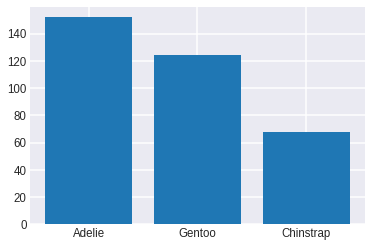

In [3]:
species_counts = dict(penguins['species'].value_counts())
plt.bar(species_counts.keys(), species_counts.values())

We are going to consider four variables as independent variables:

- bill_length_mm
- bill_depth_mm
- flipper_length_mm
- body_mass_g

In [4]:
penguins = penguins.copy()[['species',
                        'bill_length_mm',
                        'bill_depth_mm',
                        'flipper_length_mm',
                        'body_mass_g']]
                        
penguins.dropna(inplace=True)
penguins.head()

,species,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g
0,Adelie,39.1,18.7,181.0,3750.0
1,Adelie,39.5,17.4,186.0,3800.0
2,Adelie,40.3,18.0,195.0,3250.0
4,Adelie,36.7,19.3,193.0,3450.0
5,Adelie,39.3,20.6,190.0,3650.0


An easy and intuitive way of taking a first glance to our data is by doing a seaborn scatter matrix:

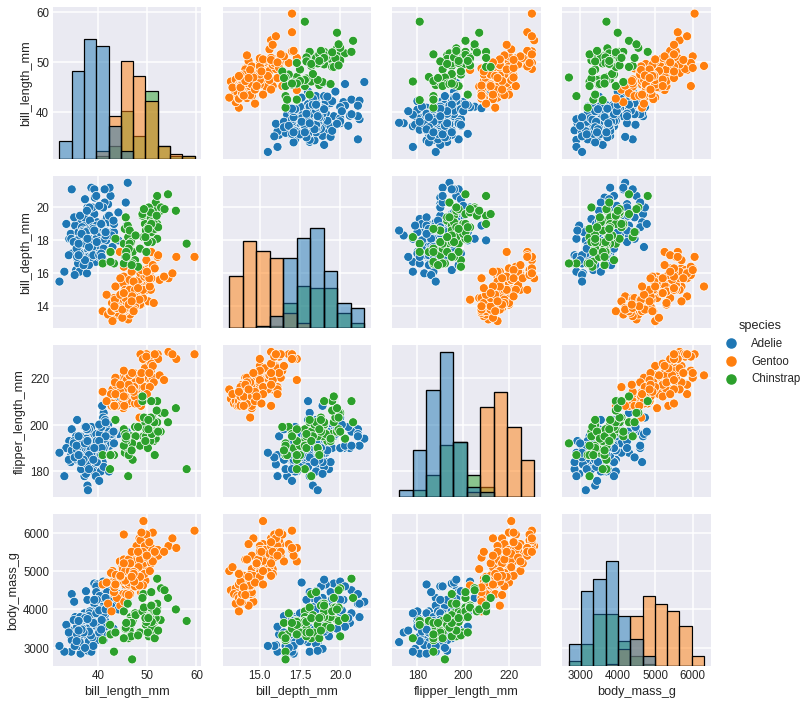

In [5]:
g = sns.PairGrid(penguins, hue="species")
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)
g.add_legend()

## 2. Binary univariate classification

Again, we start by the most simple case, a two-class classification. We will just consider species `Adelie` and `Chinstrap`, i.e., $y \in \{0,1\}$. Again, here we will employ just independent variable, `flipper_length_mm`, i.e., $x \in \mathbb R$.

In [6]:
species = ['Adelie', 'Chinstrap']

p1 = penguins[penguins['species'].isin(species)]
y_0 = ((p1['species'] == species[0])*1).values
N=len(y_0)
ind_vars = 'flipper_length_mm'
x_0 = p1[ind_vars].values.reshape((N, 1))

We can observe the distribution of our two 1-dimensional clusters with a violin plot:

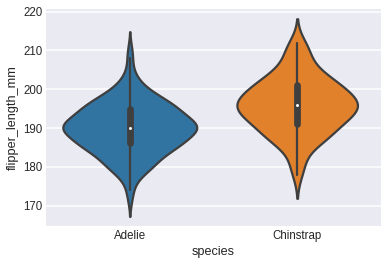

In [7]:
sns.violinplot(data=p1[['species','flipper_length_mm']], x='species', y='flipper_length_mm')
plt.show()

Now that we have the data, we need to specify the model, that is, our prior distribution and likelihood. As the likelihood, we will chose a Bernoulli $(p= \theta )$ distribution, and for the priors we select $N(\mu=0, \sigma=10)$ for $\alpha$ and $N(\mu=0, \sigma=1)$ for $\beta$. Let's also normalize the data.

In [8]:
x_0s = (x_0 - x_0.mean(axis=0))/x_0.std(axis=0)

In [9]:
# Model definition

def joint_log_prob(X_data_, Y_data_, alpha, beta):
    
    # create random variables for priors for alpha and beta
    rv_beta = tfd.Normal(name="beta", loc=0., scale=1.)
    rv_alpha = tfd.Normal(name="alpha", loc=0., scale=10.)
    
    logistic_p = 1.0/(1. + tf.exp(beta * X_data_ + alpha))
    rv_observed = tfd.Bernoulli(probs=logistic_p)
    
    return (
        rv_alpha.log_prob(alpha) 
        + rv_beta.log_prob(beta) 
        + tf.reduce_sum(rv_observed.log_prob(Y_data_))
    )

In [10]:
# Sampling from Hamiltonian Monte Carlo

number_of_steps = 4000
burnin = 800

# Set the chain's start state.
initial_chain_state = [
    tf.cast(x=1.,dtype=tf.float32) * tf.ones([], name='init_alpha', dtype=tf.float32),
    tf.cast(x=1,dtype=tf.float32) * tf.ones([], name='init_beta', dtype=tf.float32)
]

# Since HMC operates over unconstrained space, we need to transform the
# samples so they live in real-space.
unconstraining_bijectors = [
    tfp.bijectors.Identity(),
    tfp.bijectors.Identity()
]

# Define a closure over our joint_log_prob.
unnormalized_posterior_log_prob = lambda *args: joint_log_prob(x_0s, y_0, *args)

# Initialize the step_size. (It will be automatically adapted.)
with tf.compat.v1.variable_scope(tf.compat.v1.get_variable_scope(), reuse=tf.compat.v1.AUTO_REUSE):
    step_size = tf.compat.v1.get_variable(
        name='step_size',
        initializer=tf.constant(0.5, dtype=tf.float32),
        trainable=False,
        use_resource=True
    )
    
# Initialize the step_size_adaptation_step_counter, else you get TF error messages
with tf.compat.v1.variable_scope(tf.compat.v1.get_variable_scope(), reuse=tf.compat.v1.AUTO_REUSE):
    step_size_adaptation_step_counter = tf.compat.v1.get_variable(
        name='step_size_adaptation_step_counter',
        initializer=tf.constant(0.0, dtype=tf.float32),
        trainable=False,
        use_resource=True
    )    
    # Defining the HMC
    hmc=tfp.mcmc.TransformedTransitionKernel(
        inner_kernel=tfp.mcmc.HamiltonianMonteCarlo(
            target_log_prob_fn=unnormalized_posterior_log_prob,
            num_leapfrog_steps=2,
            step_size=step_size,
            step_size_update_fn= tfp.mcmc.make_simple_step_size_update_policy(num_adaptation_steps=int(burnin*0.9)),
            state_gradients_are_stopped=True),
        bijector=unconstraining_bijectors)

# Sampling from the chain.
[
    posterior_alpha,
    posterior_beta
], kernel_results = tfp.mcmc.sample_chain(
    num_results = number_of_steps,
    num_burnin_steps = burnin, # HMC gets rid of our burnin iterations automatically
    current_state=initial_chain_state,
    kernel=hmc,
    name='HMC_sampling'
)

# Initialize any created variables for preconditions
init_g = tf.compat.v1.global_variables_initializer()

Instructions for updating:
Use tfp.mcmc.SimpleStepSizeAdaptation instead.


/usr/local/lib/python3.7/dist-packages/tensorflow_probability/python/mcmc/internal/util.py:370: UserWarning: `step_size` is not a `tf.Tensor`, Python number, or Numpy array. If this parameter is mutable (e.g., a `tf.Variable`), then the behavior implied by `store_parameters_in_results` will silently change on 2019-08-01. Please consult the docstring for `store_parameters_in_results` details and use `store_parameters_in_results=True` to silence this warning.
  param_name))
/usr/local/lib/python3.7/dist-packages/tensorflow_probability/python/mcmc/sample.py:339: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn('Tracing all kernel results by default is deprecated. Set '


In [11]:
# Evaluating the graph generated above

def evaluate(tensors):
    if tf.executing_eagerly():
         return tf.nest.pack_sequence_as(
             tensors,
             [t.numpy() if tf.is_tensor(t) else t
             for t in tf.nest.flatten(tensors)])
    with tf.Session() as sess:
        return sess.run(tensors)
    
#print(tf.executing_eagerly())

evaluate(init_g)

[
    posterior_alpha_,
    posterior_beta_,
    kernel_results_
] = evaluate([
    posterior_alpha,
    posterior_beta,
    kernel_results
])

print("acceptance rate: {}".format(
    kernel_results_.inner_results.is_accepted.mean()))
print("final step size: {}".format(
    kernel_results_.inner_results.extra.step_size_assign[-100:].mean()))

acceptance rate: 0.60875
final step size: 0.016308624297380447


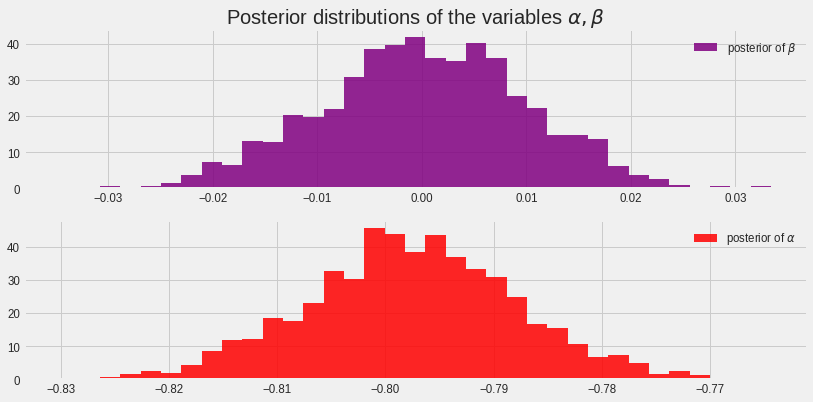

In [12]:
matplotlib_style = 'fivethirtyeight'
import matplotlib.pyplot as plt; plt.style.use(matplotlib_style)
import matplotlib.axes as axes;
from IPython.core.pylabtools import figsize

plt.figure(figsize(12.5, 6))

plt.subplot(211)
plt.title(r"Posterior distributions of the variables $\alpha, \beta$")
plt.hist(posterior_beta_, histtype='stepfilled', bins=35, alpha=0.85,
         label=r"posterior of $\beta$", color='purple', density=True)
plt.legend()

plt.subplot(212)
plt.hist(posterior_alpha_, histtype='stepfilled', bins=35, alpha=0.85,
         label=r"posterior of $\alpha$", color='red', density=True)
plt.legend()
plt.show()

In [13]:
trace_posterior_alpha = posterior_alpha_[burnin:]
trace_posterior_beta = posterior_beta_[burnin:]

inference_data = az.convert_to_inference_data({
    'p_alpha': tf.transpose(trace_posterior_alpha),
    'p_beta': tf.transpose(trace_posterior_beta)
})

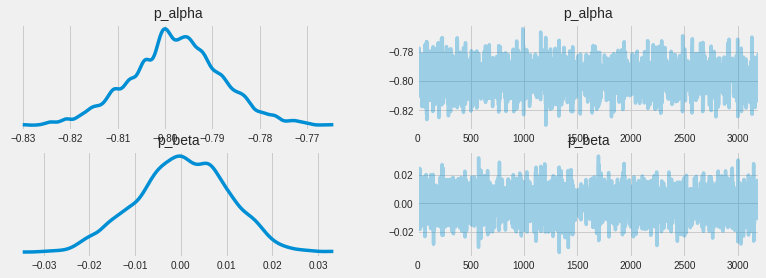

In [14]:
az.plot_trace(inference_data)
plt.show()

In [15]:
az.summary(inference_data)

arviz - WARNING - Shape validation failed: input_shape: (1, 3200), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
p_alpha,-0.798,0.01,-0.816,-0.780,0.0,0.0,3173.0,1744.0,NaN
p_beta,0.000,0.01,-0.018,0.019,0.0,0.0,3045.0,1579.0,NaN


## 2. Binary multivariate classification

Now, for the dependent variable we are going to use the two classes (Adelie, and Chinstrap), and the four considered dependent variables. Also, we normalize the data.

In [16]:
species = ['Adelie', 'Chinstrap']

p1 = penguins[penguins['species'].isin(species)]
y = ((p1['species'] == species[0])*1).values
ind_vars = ['bill_length_mm',
                        'bill_depth_mm',
                        'flipper_length_mm',
                        'body_mass_g']
x = p1[ind_vars].values

x_s = (x - x.mean(axis=0))/x.std(axis=0)

We define our model:

In [17]:
# Model definition

from numpy import exp
 
def joint_log_prob(X_data_, Y_data_, alpha, beta_0, beta_1, beta_2, beta_3):
    
    # create random variables for priors for alpha and beta
    rv_alpha = tfd.Normal(name="alpha", loc=0, scale=10) 
    # rv_beta = tfd.MultivariateNormalDiag(name="beta", loc=[0.,0.,0.,0.], scale_diag=[1.,1.,1.,1.]) 
    # rv_beta = tfd.Normal(name="beta", loc=[0.,0.,0.,0.], scale=[1.,1.,1.,1.]) 
    rv_beta_0 = tfd.Normal(name="beta_0", loc=0., scale=1.)
    rv_beta_1 = tfd.Normal(name="beta_1", loc=0., scale=1.)
    rv_beta_2 = tfd.Normal(name="beta_2", loc=0., scale=1.)
    rv_beta_3 = tfd.Normal(name="beta_3", loc=0., scale=1.)

    logistic_p = 1.0/(1. + tf.exp(beta_0 * X_data_[:, 0] + beta_1 * X_data_[:, 1] + beta_2 * X_data_[:, 2] + beta_3 * X_data_[:, 3] + alpha))
    rv_observed = tfd.Bernoulli(probs=logistic_p)
    
    return (
        rv_alpha.log_prob(alpha) 
        + rv_beta_0.log_prob(beta_0) 
        + rv_beta_1.log_prob(beta_1) 
        + rv_beta_2.log_prob(beta_2) 
        + rv_beta_3.log_prob(beta_3) 
        + tf.reduce_sum(rv_observed.log_prob(Y_data_))
    )

In [18]:
# Sampling from Hamiltonian Monte Carlo

number_of_steps = 4000
burnin = 800

# Set the chain's start state.
initial_chain_state = [
    tf.cast(x=1.,dtype=tf.float32) * tf.ones([], name='init_alpha', dtype=tf.float32),
    tf.cast(x=1,dtype=tf.float32) * tf.ones([], name='init_beta_0', dtype=tf.float32),
    tf.cast(x=1,dtype=tf.float32) * tf.ones([], name='init_beta_1', dtype=tf.float32),
    tf.cast(x=1,dtype=tf.float32) * tf.ones([], name='init_beta_2', dtype=tf.float32),
    tf.cast(x=1,dtype=tf.float32) * tf.ones([], name='init_beta_3', dtype=tf.float32)
]

# Since HMC operates over unconstrained space, we need to transform the
# samples so they live in real-space.
unconstraining_bijectors = [
    tfp.bijectors.Identity(),
    tfp.bijectors.Identity(),
    tfp.bijectors.Identity(),
    tfp.bijectors.Identity(),
    tfp.bijectors.Identity()
]

# Define a closure over our joint_log_prob.
unnormalized_posterior_log_prob = lambda *args: joint_log_prob(x_s, y, *args)

# Initialize the step_size. (It will be automatically adapted.)
with tf.compat.v1.variable_scope(tf.compat.v1.get_variable_scope(), reuse=tf.compat.v1.AUTO_REUSE):
    step_size = tf.compat.v1.get_variable(
        name='step_size',
        initializer=tf.constant(0.5, dtype=tf.float32),
        trainable=False,
        use_resource=True
    )
    
# Initialize the step_size_adaptation_step_counter, else you get TF error messages
with tf.compat.v1.variable_scope(tf.compat.v1.get_variable_scope(), reuse=tf.compat.v1.AUTO_REUSE):
    step_size_adaptation_step_counter = tf.compat.v1.get_variable(
        name='step_size_adaptation_step_counter',
        initializer=tf.constant(0.0, dtype=tf.float32),
        trainable=False,
        use_resource=True
    )    
    # Defining the HMC
    hmc=tfp.mcmc.TransformedTransitionKernel(
        inner_kernel=tfp.mcmc.HamiltonianMonteCarlo(
            target_log_prob_fn=unnormalized_posterior_log_prob,
            num_leapfrog_steps=2,
            step_size=step_size,
            step_size_update_fn= tfp.mcmc.make_simple_step_size_update_policy(num_adaptation_steps=int(burnin*0.9)),
            state_gradients_are_stopped=True),
        bijector=unconstraining_bijectors)

# Sampling from the chain.
[
    posterior_alpha,
    posterior_beta_0,
    posterior_beta_1,
    posterior_beta_2,
    posterior_beta_3
], kernel_results = tfp.mcmc.sample_chain(
    num_results = number_of_steps,
    num_burnin_steps = burnin, # HMC gets rid of our burnin iterations automatically
    current_state=initial_chain_state,
    kernel=hmc,
    name='HMC_sampling'
)

# Initialize any created variables for preconditions
init_g = tf.compat.v1.global_variables_initializer()

/usr/local/lib/python3.7/dist-packages/tensorflow_probability/python/mcmc/internal/util.py:370: UserWarning: `step_size` is not a `tf.Tensor`, Python number, or Numpy array. If this parameter is mutable (e.g., a `tf.Variable`), then the behavior implied by `store_parameters_in_results` will silently change on 2019-08-01. Please consult the docstring for `store_parameters_in_results` details and use `store_parameters_in_results=True` to silence this warning.
  param_name))
/usr/local/lib/python3.7/dist-packages/tensorflow_probability/python/mcmc/sample.py:339: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn('Tracing all kernel results by default is deprecated. Set '


In [19]:
# Evaluating the graph generated above

def evaluate(tensors):
    if tf.executing_eagerly():
         return tf.nest.pack_sequence_as(
             tensors,
             [t.numpy() if tf.is_tensor(t) else t
             for t in tf.nest.flatten(tensors)])
    with tf.Session() as sess:
        return sess.run(tensors)
    
#print(tf.executing_eagerly())

evaluate(init_g)

[
    posterior_alpha_,
    posterior_beta_0_,
    posterior_beta_1_,
    posterior_beta_2_,
    posterior_beta_3_,
    kernel_results_
] = evaluate([
    posterior_alpha,
    posterior_beta_0,
    posterior_beta_1,
    posterior_beta_2,
    posterior_beta_3,
    kernel_results
])

print("acceptance rate: {}".format(
    kernel_results_.inner_results.is_accepted.mean()))
print("final step size: {}".format(
    kernel_results_.inner_results.extra.step_size_assign[-100:].mean()))

acceptance rate: 0.6345
final step size: 0.3564867377281189


Posterior distributions.

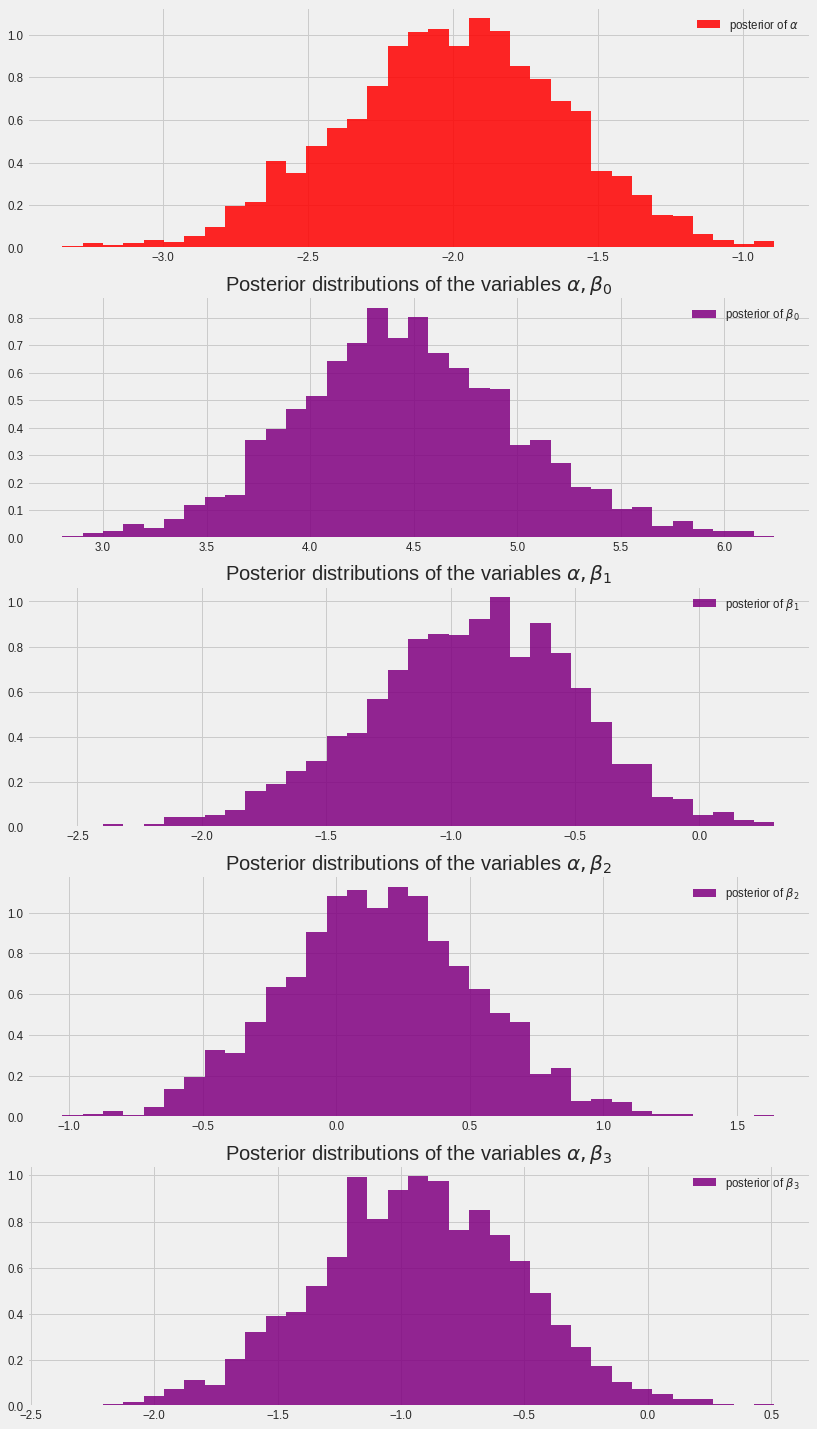

In [20]:
matplotlib_style = 'fivethirtyeight'
import matplotlib.pyplot as plt; plt.style.use(matplotlib_style)
import matplotlib.axes as axes;
from IPython.core.pylabtools import figsize

plt.figure(figsize(12.5, 24))

plt.subplot(511)
plt.hist(posterior_alpha_, histtype='stepfilled', bins=35, alpha=0.85,
         label=r"posterior of $\alpha$", color='red', density=True)
plt.legend()

plt.subplot(512)
plt.title(r"Posterior distributions of the variables $\alpha, \beta_0$")
plt.hist(posterior_beta_0_, histtype='stepfilled', bins=35, alpha=0.85,
         label=r"posterior of $\beta_0$", color='purple', density=True)
plt.legend()

plt.subplot(513)
plt.title(r"Posterior distributions of the variables $\alpha, \beta_1$")
plt.hist(posterior_beta_1_, histtype='stepfilled', bins=35, alpha=0.85,
         label=r"posterior of $\beta_1$", color='purple', density=True)
plt.legend()

plt.subplot(514)
plt.title(r"Posterior distributions of the variables $\alpha, \beta_2$")
plt.hist(posterior_beta_2_, histtype='stepfilled', bins=35, alpha=0.85,
         label=r"posterior of $\beta_2$", color='purple', density=True)
plt.legend()

plt.subplot(515)
plt.title(r"Posterior distributions of the variables $\alpha, \beta_3$")
plt.hist(posterior_beta_3_, histtype='stepfilled', bins=35, alpha=0.85,
         label=r"posterior of $\beta_3$", color='purple', density=True)
plt.legend()
plt.show()

In [21]:
trace_posterior_alpha = posterior_alpha_[burnin:]
trace_posterior_beta_0 = posterior_beta_0_[burnin:]
trace_posterior_beta_1 = posterior_beta_1_[burnin:]
trace_posterior_beta_2 = posterior_beta_2_[burnin:]
trace_posterior_beta_3 = posterior_beta_3_[burnin:]

inference_data = az.convert_to_inference_data({
    'p_alpha': tf.transpose(trace_posterior_alpha),
    'p_beta_0': tf.transpose(trace_posterior_beta_0),
    'p_beta_1': tf.transpose(trace_posterior_beta_1),
    'p_beta_2': tf.transpose(trace_posterior_beta_2),
    'p_beta_3': tf.transpose(trace_posterior_beta_3),
})

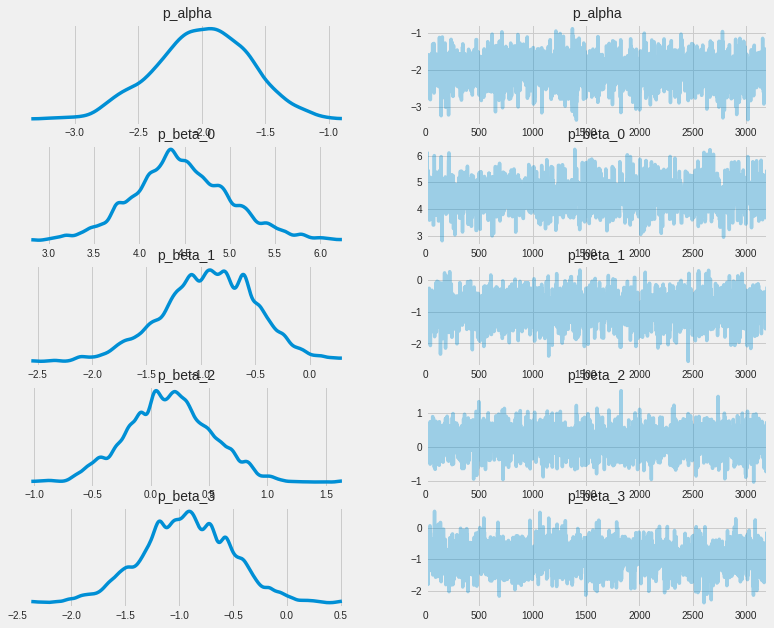

In [22]:
az.plot_trace(inference_data)
plt.show()

In [23]:
az.summary(inference_data)

arviz - WARNING - Shape validation failed: input_shape: (1, 3200), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
p_alpha,-2.001,0.382,-2.760,-1.347,0.009,0.007,1709.0,1236.0,NaN
p_beta_0,4.469,0.538,3.462,5.507,0.018,0.013,878.0,923.0,NaN
p_beta_1,-0.918,0.432,-1.777,-0.158,0.012,0.009,1334.0,1202.0,NaN
p_beta_2,0.162,0.358,-0.474,0.862,0.008,0.007,1997.0,1422.0,NaN
p_beta_3,-0.931,0.413,-1.681,-0.142,0.012,0.009,1104.0,1069.0,NaN
